In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import os, os.path

DIR = '/content/gdrive/My Drive/APTOS1/test_images/'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))


DIR2 = '/content/gdrive/My Drive/APTOS1/train_images/'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

3862
3862


In [ ]:
%tensorflow_version 2.x

In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
#from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tqdm import tqdm

%matplotlib inline

In [ ]:
train_df = pd.read_csv('/content/gdrive/My Drive/APTOS1/train.csv')
test_df = pd.read_csv('/content/gdrive/My Drive/APTOS1/test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(3662, 2)
(1928, 1)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [ ]:
import multiprocessing
from multiprocessing.pool import ThreadPool
print(multiprocessing.cpu_count()," CPU cores")

4  CPU cores


In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [ ]:
def circle_crop(img, sigmaX = 30):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

In [ ]:
from PIL import Image

def resize(image_pil, width, height):
    '''
    Resize PIL image keeping ratio and using white background.
    '''
    ratio_w = width / image_pil.width
    ratio_h = height / image_pil.height
    if ratio_w < ratio_h:

        resize_width = width
        resize_height = round(ratio_w * image_pil.height)
    else:

        resize_width = round(ratio_h * image_pil.width)
        resize_height = height
    image_resize = image_pil.resize((resize_width, resize_height), Image.ANTIALIAS)
    background = Image.new('RGBA', (width, height), (0, 0, 0, 0)) #fondo negro o blanco
    offset = (round((width - resize_width) / 2), round((height - resize_height) / 2))
    background.paste(image_resize, offset)
    return background.convert('RGB')

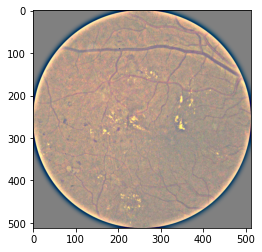

In [ ]:
N = train_df.shape[0]
x_train = np.zeros((N, 512, 512, 3), dtype='uint8')

img = cv2.imread('/content/gdrive/My Drive/APTOS1/train_images/000c1434d8d7.png')
img=circle_crop(img)
pilim =Image.fromarray(img)
img= resize(pilim,512,512)
imga=np.array(img) 
plt.imshow(imga)

In [ ]:
N = train_df.shape[0]
x_train = np.zeros((N, 512, 512, 3), dtype='uint8')

for i, image_id in enumerate(tqdm(train_df['id_code'])):
  img = cv2.imread(f'/content/gdrive/My Drive/APTOS1/train_images/{image_id}.png')
  img=circle_crop(img)
  pilim =Image.fromarray(img)
  img= resize(pilim,512,512)
  imga=np.array(img) 
  x_train[i,:,:,:] = imga

100%|██████████| 3662/3662 [49:49<00:00,  1.22it/s]


In [ ]:
y = pd.get_dummies(train_df['diagnosis']).values

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y, 
    test_size=0.15, 
    random_state=2020
)

In [ ]:
FACTOR = 4
BATCH_SIZE = 8 * FACTOR
IMG_SIZE = 512
EPOCHS = 20
WARMUP_EPOCHS = 5
LEARNING_RATE = 1e-4 * FACTOR
WARMUP_LEARNING_RATE = 1e-3 * FACTOR
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = train_df['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

LR_WARMUP_EPOCHS_1st = 2
LR_WARMUP_EPOCHS_2nd = 5
STEP_SIZE = len(x_train) // BATCH_SIZE
TOTAL_STEPS_1st = WARMUP_EPOCHS * STEP_SIZE
TOTAL_STEPS_2nd = EPOCHS * STEP_SIZE
WARMUP_STEPS_1st = LR_WARMUP_EPOCHS_1st * STEP_SIZE
WARMUP_STEPS_2nd = LR_WARMUP_EPOCHS_2nd * STEP_SIZE

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
def multiple_outputs(generator,x, y, batch_size):
    gen = generator.flow(x, y, batch_size=batch_size, seed=2020)
    
    mlb = MultiLabelBinarizer(classes = range(N_CLASSES))
    
    while True:
        gnext = gen.next()
        yield gnext[0], [np.argmax(gnext[1],axis = -1),gnext[1],mlb.fit_transform([list(range(x+1)) for x in np.argmax(gnext[1],axis = -1)])]

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255, rotation_range=360,
                                 horizontal_flip=True,
                                 vertical_flip=True)

gen =train_datagen.flow(x_train,y_train,batch_size=8, seed= 2020)

In [ ]:
val_gen =train_datagen.flow(x_val,y_val,batch_size=8, seed= 2020)

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation

In [ ]:
model1 = tf.keras.Sequential()

model1.add(Conv2D(32, (3, 3), padding='same', input_shape=(512,512,3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(128, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(256, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(512, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(1024, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(4096))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))

model1.add(Flatten())
model1.add(Dense(512))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))

model1.add(Dense(5, activation='softmax'))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 512, 512, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     7

In [ ]:
densenet = tf.keras.applications.DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(512,512,3)
)

In [ ]:
model = tf.keras.Sequential()
model.add(densenet)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(5, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 16, 16, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer= 'Adam',metrics=['accuracy'])

In [ ]:
model.fit(gen,batch_size=8, epochs=30, validation_data=val_gen,callbacks=[])

Epoch 1/30
389/389 [==============================] - 193s 496ms/step - loss: 1.1829 - accuracy: 0.5990 - val_loss: 29.3137 - val_accuracy: 0.5400
Epoch 2/30
389/389 [==============================] - 189s 487ms/step - loss: 0.8933 - accuracy: 0.6870 - val_loss: 0.8621 - val_accuracy: 0.7636
Epoch 3/30
389/389 [==============================] - 187s 480ms/step - loss: 0.8303 - accuracy: 0.7175 - val_loss: 0.7805 - val_accuracy: 0.7309
Epoch 4/30
389/389 [==============================] - 187s 481ms/step - loss: 0.8008 - accuracy: 0.7227 - val_loss: 0.7117 - val_accuracy: 0.7509
Epoch 5/30
389/389 [==============================] - 185s 476ms/step - loss: 0.7908 - accuracy: 0.7294 - val_loss: 1.2419 - val_accuracy: 0.6255
Epoch 6/30
389/389 [==============================] - 183s 470ms/step - loss: 0.7685 - accuracy: 0.7285 - val_loss: 0.6418 - val_accuracy: 0.7782
Epoch 7/30
389/389 [==============================] - 182s 468ms/step - loss: 0.7488 - accuracy: 0.7330 - val_loss: 0.9131 

In [ ]:
val_preds = model.predict(x_val,verbose = 1)

18/18 [==============================] - 4s 208ms/step


In [ ]:
val_preds = [np.argmax(pred) for pred in val_preds]

In [ ]:
y_valpred = [np.argmax(predd) for predd in y_val]

In [ ]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(val_preds, y_valpred, weights='quadratic'))

Train Cohen Kappa score: 0.000


In [ ]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras import optimizers,Model,Sequential

In [ ]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])

In [ ]:
history_finetunning = model.fit_generator(generator=gen,validation_data=val_gen,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
389/389 [==============================] - 177s 455ms/step - loss: 0.2030 - accuracy: 0.7699 - val_loss: 0.1844 - val_accuracy: 0.7927
Epoch 2/20
389/389 [==============================] - 176s 451ms/step - loss: 0.1936 - accuracy: 0.7722 - val_loss: 0.1761 - val_accuracy: 0.7927
Epoch 3/20
389/389 [==============================] - 178s 459ms/step - loss: 0.1932 - accuracy: 0.7786 - val_loss: 0.1973 - val_accuracy: 0.7618
Epoch 4/20
389/389 [==============================] - 177s 454ms/step - loss: 0.1949 - accuracy: 0.7696 - val_loss: 0.1853 - val_accuracy: 0.7855
Epoch 5/20
389/389 [==============================] - ETA: 0s - loss: 0.1922 - accuracy: 0.7808
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.
389/389 [==============================] - 176s 451ms/step - loss: 0.1922 - accuracy: 0.7808 - val_loss: 0.1872 - val_accuracy: 0.8091
Epoch 6/20
389/389 [========

In [ ]:
val_preds = model.predict(x_val,verbose = 1)

18/18 [==============================] - 4s 209ms/step


In [ ]:
val_preds

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
val_preds = [np.argmax(pred) for pred in val_preds]

In [ ]:
y_valpred = [np.argmax(predd) for predd in y_val]

In [ ]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(val_preds, y_valpred, weights='quadratic'))

Train Cohen Kappa score: 0.000


In [ ]:
model1.fit(gen,batch_size=8, epochs=30, validation_data=val_gen,callbacks=[])

Epoch 1/30
389/389 [==============================] - 221s 568ms/step - loss: 1.3921 - accuracy: 0.4778 - val_loss: 1.2732 - val_accuracy: 0.5400
Epoch 2/30
389/389 [==============================] - 225s 577ms/step - loss: 1.3209 - accuracy: 0.4839 - val_loss: 1.2418 - val_accuracy: 0.5400
Epoch 3/30
389/389 [==============================] - 217s 559ms/step - loss: 1.3115 - accuracy: 0.4849 - val_loss: 1.2400 - val_accuracy: 0.5400
Epoch 4/30
389/389 [==============================] - 213s 548ms/step - loss: 1.3136 - accuracy: 0.4852 - val_loss: 1.2389 - val_accuracy: 0.5400
Epoch 5/30
389/389 [==============================] - 210s 540ms/step - loss: 1.3165 - accuracy: 0.4846 - val_loss: 1.2503 - val_accuracy: 0.5400
Epoch 6/30
389/389 [==============================] - 209s 538ms/step - loss: 1.3110 - accuracy: 0.4846 - val_loss: 1.2402 - val_accuracy: 0.5400
Epoch 7/30
389/389 [==============================] - 210s 540ms/step - loss: 1.3097 - accuracy: 0.4846 - val_loss: 1.2379 -

KeyboardInterrupt: ignored